In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Reshape, Concatenate, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import scipy.io as sio

In [54]:
# Solve the problem of the minus sign '-' showing as a square when saving images
plt.rcParams['axes.unicode_minus'] = False

In [55]:
vp_orig = sio.loadmat('./model data/vp.mat')['vp']
vs_orig = sio.loadmat('./model data/vs.mat')['vs']
dn_orig = sio.loadmat('./model data/dn.mat')['dn']
cnl_orig = sio.loadmat('./model data/cnl.mat')['cnl']
gr_orig = sio.loadmat('./model data/gr.mat')['gr']

In [56]:
vp, vs, dn, cnl, gr = vp_orig.copy(), vs_orig.copy(), dn_orig.copy(), cnl_orig.copy(), gr_orig.copy()

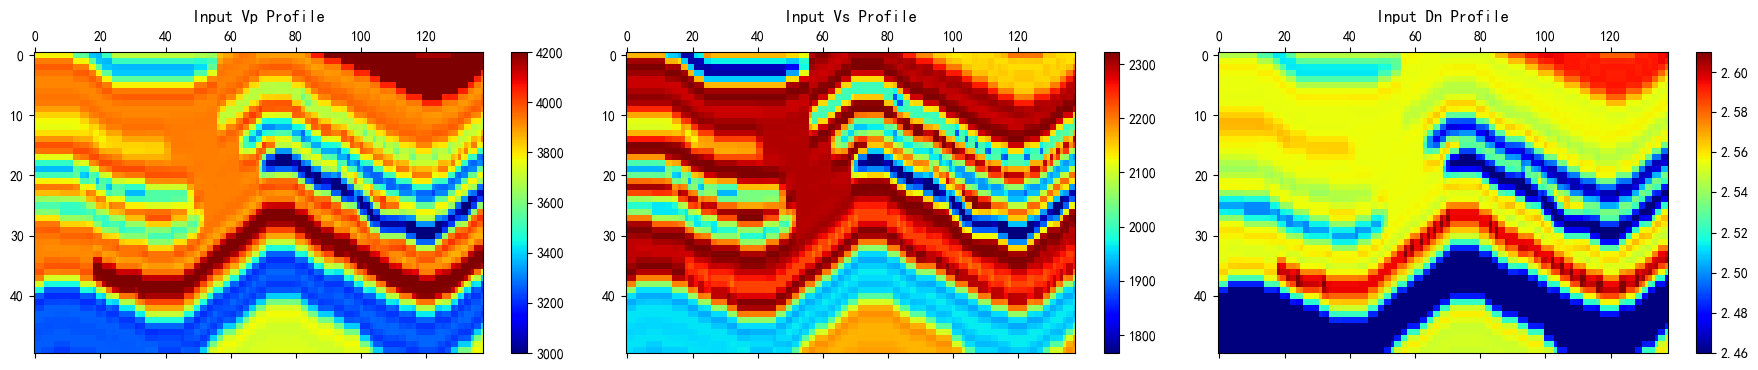

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
# Vp Profile
im1 = axes[0].matshow(vp_orig, aspect='auto', cmap='jet', vmin=3000, vmax=4200)
axes[0].set_title('Input Vp Profile')
fig.colorbar(im1, ax=axes[0])

# Vs Profile
im2 = axes[1].matshow(vs_orig, aspect='auto', cmap='jet', vmin=1767, vmax=2322)
axes[1].set_title('Input Vs Profile')
fig.colorbar(im2, ax=axes[1])

# Dn Profile
im3 = axes[2].matshow(dn_orig, aspect='auto', cmap='jet', vmin=2.46, vmax=2.61)
axes[2].set_title('Input Dn Profile')
fig.colorbar(im3, ax=axes[2])

plt.tight_layout(rect=[0, 0, 1, 0.95])

In [58]:
scaler_vp = StandardScaler()
scaler_vs = StandardScaler()
scaler_dn = StandardScaler()
scaler_cnl = StandardScaler()
scaler_gr = StandardScaler()
vp = scaler_vp.fit_transform(vp)
vs = scaler_vs.fit_transform(vs)
dn = scaler_dn.fit_transform(dn)
cnl = scaler_cnl.fit_transform(cnl)
gr = scaler_gr.fit_transform(gr)

print("Data loading and standardization complete.")
print("VP data shape:", vp.shape)

Data loading and standardization complete.
VP data shape: (50, 138)


In [59]:
def create_dataset2(X, y, seq_len):
    features = []
    targets = []
    for i in range(len(X) - seq_len):
        data = X[i:i+seq_len]
        label = y[i + seq_len // 2]
        features.append(data)
        targets.append(label)
    return np.array(features), np.array(targets)

In [60]:
# Define a function to process the entire dataset
def process_data(data, data_name, seq_len):
    all_features, all_targets = [], []
    for col in range(data.shape[1]):
        features, targets = create_dataset2(data[:, col], data[:, col], seq_len)
        all_features.append(features)
        all_targets.append(targets)
    all_features = np.stack(all_features, axis=1)
    all_targets = np.stack(all_targets, axis=1)
    print(f"{data_name}_features shape: {all_features.shape}")
    return all_features, all_targets

In [61]:
# Set sequence length and process all data
Len1 = 3
vp_all_features, _ = process_data(vp, 'vp', Len1)
vs_all_features, _ = process_data(vs, 'vs', Len1)
dn_all_features, _ = process_data(dn, 'dn', Len1)
_, cnl_all_targets = process_data(cnl, 'cnl', Len1)
_, gr_all_targets = process_data(gr, 'gr', Len1)

# Combine input features (Vp, Vs, Dn)
vp_all_features_exp = np.expand_dims(vp_all_features, axis=-1)
vs_all_features_exp = np.expand_dims(vs_all_features, axis=-1)
dn_all_features_exp = np.expand_dims(dn_all_features, axis=-1)
vpvsden_fea = np.concatenate((vp_all_features_exp, vs_all_features_exp, dn_all_features_exp), axis=3)
print("\nCombined input feature shape:", vpvsden_fea.shape)

vp_features shape: (47, 138, 3)
vs_features shape: (47, 138, 3)
dn_features shape: (47, 138, 3)
cnl_features shape: (47, 138, 3)
gr_features shape: (47, 138, 3)

Combined input feature shape: (47, 138, 3, 3)


In [62]:
### 5. Prepare Training and Test Data
# Define training well indices
train_well_indices = [10, 35, 61, 98, 130]

# Extract training well data from total features and labels
six_well_fea = vpvsden_fea[:, train_well_indices, :, :]
six_well_gr_target = gr_all_targets[:, train_well_indices]
six_well_cnl_target = cnl_all_targets[:, train_well_indices]

# Adjust data dimensions to fit model input
# Features (num_samples * num_wells, seq_len, num_features) -> (num_samples * num_wells, seq_len * num_features)
num_samples, num_wells, seq_len, num_features = six_well_fea.shape
X_train = six_well_fea.reshape(num_samples * num_wells, seq_len * num_features)

# Labels (num_samples * num_wells)
y_train_gr = six_well_gr_target.reshape(num_samples * num_wells)
y_train_cnl = six_well_cnl_target.reshape(num_samples * num_wells)

print("\nTraining data preparation complete:")
print("X_train shape:", X_train.shape)
print("y_train_gr shape:", y_train_gr.shape)
print("y_train_cnl shape:", y_train_cnl.shape)


Training data preparation complete:
X_train shape: (235, 9)
y_train_gr shape: (235,)
y_train_cnl shape: (235,)


In [63]:
def build_multi_output_stabgcn_model(input_shape):
    """
    Multi-output STABGCN model for simultaneous GR and CNL prediction
    """
    inputs = Input(shape=input_shape)
    features = input_shape[0]
    
    # --- 2D-CNN Branch ---
    side_length = int(np.ceil(np.sqrt(features)))
    padding_needed = side_length * side_length - features
    x_padded = tf.pad(inputs, [[0, 0], [0, padding_needed]])
    reshaped_2d = Reshape((side_length, side_length, 1))(x_padded)
    conv2d = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(reshaped_2d)
    pool = MaxPooling2D((2, 2))(conv2d)
    dropout_cnn = Dropout(0.2)(pool)
    cnn_flat = Flatten()(dropout_cnn)
    
    # --- BiGRU Branch ---
    seq_length = features // 3
    x_seq = Reshape((seq_length, 3))(inputs[:, :seq_length*3])
    bigru = Bidirectional(GRU(32, recurrent_regularizer=tf.keras.regularizers.l2(0.001), kernel_regularizer=tf.keras.regularizers.l2(0.001)))(x_seq)
    dropout_gru = Dropout(0.2)(bigru)
    
    # Merge features
    merged = Concatenate()([cnn_flat, dropout_gru])
    
    # Shared layers
    shared = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged)
    shared_dropout = Dropout(0.2)(shared)
    
    # GR prediction branch
    gr_branch = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(shared_dropout)
    gr_dropout = Dropout(0.2)(gr_branch)
    gr_output = Dense(1, name='gr_output')(gr_dropout)
    
    # CNL prediction branch
    cnl_branch = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(shared_dropout)
    cnl_dropout = Dropout(0.2)(cnl_branch)
    cnl_output = Dense(1, name='cnl_output')(cnl_dropout)
    
    model = Model(inputs=inputs, outputs=[gr_output, cnl_output])
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer, 
                  loss={'gr_output': 'mse', 'cnl_output': 'mse'},
                  loss_weights={'gr_output': 1.0, 'cnl_output': 1.0})
    return model

In [64]:
# Instantiate the model
input_shape = (X_train.shape[1],)
stabgcn_model = build_multi_output_stabgcn_model(input_shape)
stabgcn_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 tf.compat.v1.pad_3 (TFOpLa  (None, 9)                    0         ['input_4[0][0]']             
 mbda)                                                                                            
                                                                                                  
 reshape_6 (Reshape)         (None, 3, 3, 1)              0         ['tf.compat.v1.pad_3[0][0]']  
                                                                                                  
 conv2d_3 (Conv2D)           (None, 3, 3, 32)             320       ['reshape_6[0][0]']     

In [65]:
### 7. Train the Model
print("\nStarting model training...")
history = stabgcn_model.fit(
    X_train,
    {'gr_output': y_train_gr, 'cnl_output': y_train_cnl},
    epochs=15,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)
print("Model training complete.")


Starting model training...
Epoch 1/15
2/2 [==============================] - 7s 1s/step - loss: 2.2196 - gr_output_loss: 0.9490 - cnl_output_loss: 0.9117 - val_loss: 2.7252 - val_gr_output_loss: 1.2099 - val_cnl_output_loss: 1.1581
Epoch 2/15
2/2 [==============================] - 0s 38ms/step - loss: 1.7701 - gr_output_loss: 0.7838 - cnl_output_loss: 0.6295 - val_loss: 1.6737 - val_gr_output_loss: 0.8287 - val_cnl_output_loss: 0.4898
Epoch 3/15
2/2 [==============================] - 0s 37ms/step - loss: 1.4050 - gr_output_loss: 0.6631 - cnl_output_loss: 0.3871 - val_loss: 0.9788 - val_gr_output_loss: 0.4821 - val_cnl_output_loss: 0.1434
Epoch 4/15
2/2 [==============================] - 0s 37ms/step - loss: 1.1868 - gr_output_loss: 0.5575 - cnl_output_loss: 0.2763 - val_loss: 0.6643 - val_gr_output_loss: 0.2569 - val_cnl_output_loss: 0.0561
Epoch 5/15
2/2 [==============================] - 0s 37ms/step - loss: 1.0627 - gr_output_loss: 0.4979 - cnl_output_loss: 0.2137 - val_loss: 0.610

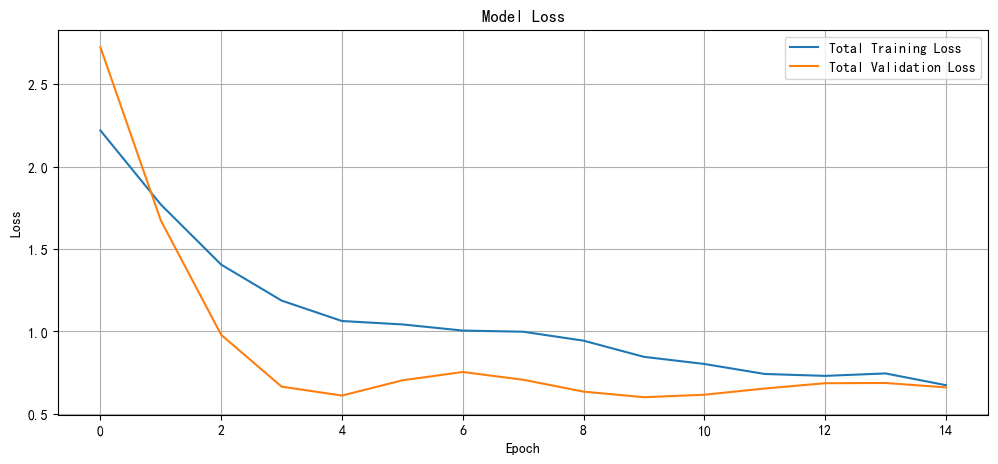

In [66]:
# Plot loss curves
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Total Training Loss')
plt.plot(history.history['val_loss'], label='Total Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
### 8. Predict on the Entire Dataset
# Prepare the complete dataset for prediction
total_samples, total_wells, _, _ = vpvsden_fea.shape
X_predict = vpvsden_fea.reshape(total_samples * total_wells, seq_len * num_features)

print("\nStarting prediction on the entire dataset...")
predictions = stabgcn_model.predict(X_predict)
predictions_gr_flat, predictions_cnl_flat = predictions[0], predictions[1]

# Reshape prediction results to a 2D profile (samples, wells)
predictions_gr = predictions_gr_flat.reshape(total_samples, total_wells)
predictions_cnl = predictions_cnl_flat.reshape(total_samples, total_wells)
print("Prediction complete. Predicted GR profile shape:", predictions_gr.shape)


Starting prediction on the entire dataset...
203/203 [==============================] - 1s 2ms/step
Prediction complete. Predicted GR profile shape: (47, 138)



Overall R² score for GR prediction: 0.7917
Overall R² score for CNL prediction: 0.9236


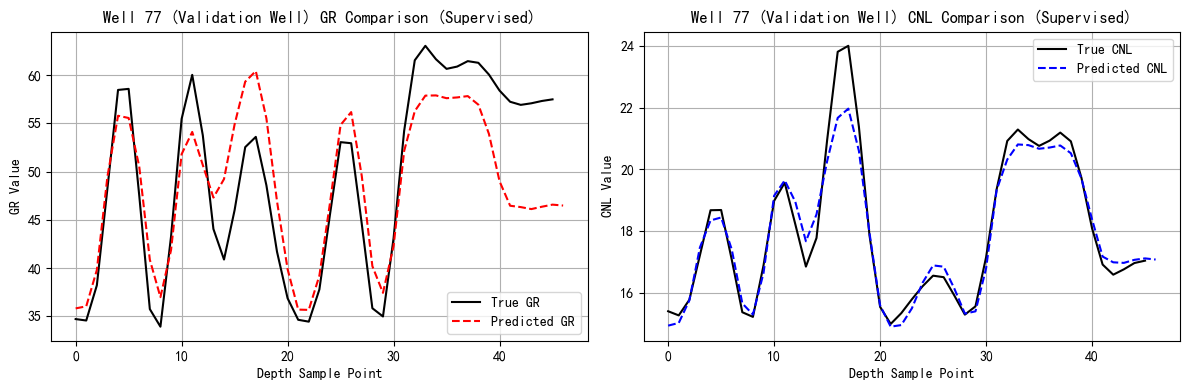

C:\Users\MJ\AppData\Local\Temp\ipykernel_9432\119071886.py:72: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
d:\study\miniconda\enviroment\envs\shit\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


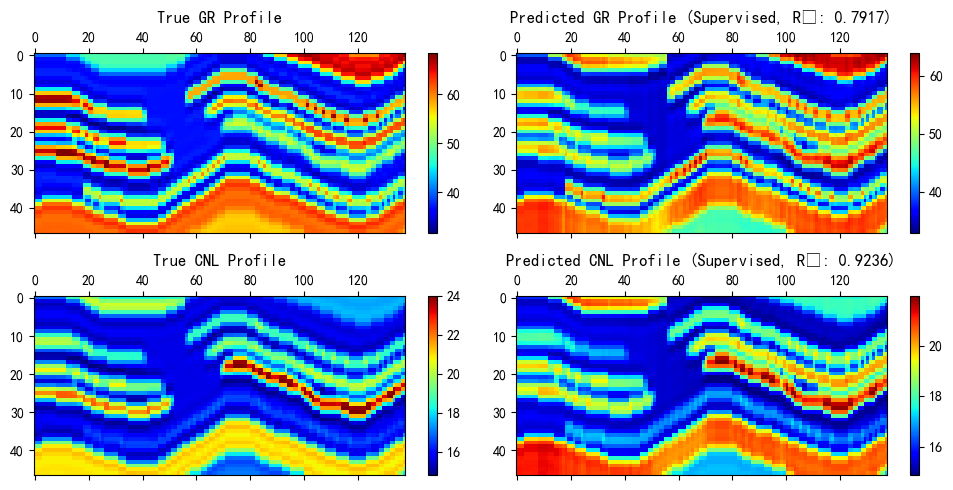

In [70]:
### 9. Evaluate and Visualize Results
# Inverse transform for comparison with original values
predictions_gr_orig = scaler_gr.inverse_transform(predictions_gr)
predictions_cnl_orig = scaler_cnl.inverse_transform(predictions_cnl)

# Get the true test labels (needs to be cropped to match prediction length)
y_test_gr_orig = gr_orig[:total_samples, :]
y_test_cnl_orig = cnl_orig[:total_samples, :]

# Calculate the average R² score for the entire dataset
r2_gr = r2_score(gr_all_targets.flatten(), predictions_gr.flatten())
r2_cnl = r2_score(cnl_all_targets.flatten(), predictions_cnl.flatten())
print(f"\nOverall R² score for GR prediction: {r2_gr:.4f}")
print(f"Overall R² score for CNL prediction: {r2_cnl:.4f}")

# Visualize comparison: choose a well not used for training (e.g., well 77)
well_idx_to_plot = 77

# Prepare data for plotting
# Due to sequence processing, the prediction length is shorter than the original data.
# True labels need to be aligned accordingly.
start_idx = (Len1 - 1) // 2
end_idx = start_idx + predictions_gr_orig.shape[0]
true_gr_well = y_test_gr_orig[start_idx:end_idx, well_idx_to_plot]
true_cnl_well = y_test_cnl_orig[start_idx:end_idx, well_idx_to_plot]
pred_gr_well = predictions_gr_orig[:, well_idx_to_plot]
pred_cnl_well = predictions_cnl_orig[:, well_idx_to_plot]

# Plotting
plt.figure(figsize=(12, 4))

# GR Comparison
plt.subplot(1, 2, 1)
plt.plot(true_gr_well, 'k-', label='True GR')
plt.plot(pred_gr_well, 'r--', label='Predicted GR')
plt.title(f'Well {well_idx_to_plot} (Validation Well) GR Comparison (Supervised)')
plt.xlabel('Depth Sample Point')
plt.ylabel('GR Value')
plt.legend()
plt.grid(True)

# CNL Comparison
plt.subplot(1, 2, 2)
plt.plot(true_cnl_well, 'k-', label='True CNL')
plt.plot(pred_cnl_well, 'b--', label='Predicted CNL')
plt.title(f'Well {well_idx_to_plot} (Validation Well) CNL Comparison (Supervised)')
plt.xlabel('Depth Sample Point')
plt.ylabel('CNL Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualize the entire profile comparison
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
# GR
im1 = axes[0, 0].matshow(y_test_gr_orig, aspect='auto', cmap='jet')
axes[0, 0].set_title('True GR Profile')
fig.colorbar(im1, ax=axes[0, 0])
im2 = axes[0, 1].matshow(predictions_gr_orig, aspect='auto', cmap='jet')
axes[0, 1].set_title(f'Predicted GR Profile (Supervised, R²: {r2_gr:.4f})')
fig.colorbar(im2, ax=axes[0, 1])
# CNL
im3 = axes[1, 0].matshow(y_test_cnl_orig, aspect='auto', cmap='jet')
axes[1, 0].set_title('True CNL Profile')
fig.colorbar(im3, ax=axes[1, 0])
im4 = axes[1, 1].matshow(predictions_cnl_orig, aspect='auto', cmap='jet')
axes[1, 1].set_title(f'Predicted CNL Profile (Supervised, R²: {r2_cnl:.4f})')
fig.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
# sio.savemat("gr_predicted_supervised.mat",{"predicted_gr":predictions_gr_orig})
# sio.savemat("cnl_predicted_supervised.mat",{"predicted_cnl":predictions_cnl_orig})